# TEST ANGULAR POWER SPECTRA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

In [2]:
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'legend.frameon': False,
    'legend.handlelength': 1.5,
})

## 1. Load DES-Y1 quantities

* Metadata

In [3]:
nbin = 5

In [4]:
bin_a, bin_b = np.tril_indices(nbin)
bin_a += 1
bin_b += 1

* Cosmology

In [5]:
cosmo = {}
with open('../../data/des-y1-test/cosmological_parameters/values.txt') as cosmo_values:
    for line in cosmo_values:
        if line:
            key, val = line.partition('=')[::2]
            cosmo[key.strip()] = float(val)

In [6]:
cosmo_astropy = FlatLambdaCDM(H0=cosmo['hubble'], Ob0=cosmo['omega_b'], Om0= cosmo['omega_m'], Tcmb0=2.7)

* Distance functions

In [7]:
zdM = np.loadtxt('../../data/des-y1-test/distances/z.txt')
dM = np.loadtxt('../../data/des-y1-test/distances/d_m.txt')

* Matter power spectrum

In [8]:
zp = np.loadtxt('../../data/des-y1-test/matter_power_nl/z.txt')
k_h = np.loadtxt('../../data/des-y1-test/matter_power_nl/k_h.txt')
p_h = np.loadtxt('../../data/des-y1-test/matter_power_nl/p_k.txt')

In [9]:
xp = np.interp(zp, zdM, dM)

In [10]:
k0, kf = k_h[0]*(cosmo['hubble']/100), k_h[-1]*(cosmo['hubble']/100)

In [11]:
k_h2 = np.logspace(np.log10(k0), np.log10(kf), 1024)
p_h2 = np.exp([np.interp(np.log(k_h2), np.log(k_h), np.log(p)) for p in p_h])

In [12]:
k = k_h2*cosmo['h0']
p = p_h2*cosmo['h0']**(-3)

* Unequal-time power spectra

In [15]:
import sys
sys.path.append("../../unequalpy")

from skypy.power_spectrum import growth_function
from approximation import growth_midpoint

In [16]:
from matter import matter_power_spectrum_1loop as P1loop
from matter import matter_unequal_time_power_spectrum as Puetc
from approximation import geometric_approx as Pgeom
from approximation import midpoint_approx as Pmid

In [15]:
d = np.loadtxt('../../data/Pfastpt.txt',unpack=True)
ks, pk, p22, p13 = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
p11_int = interp1d( ks, pk, fill_value="extrapolate")
p22_int = interp1d( ks, p22, fill_value="extrapolate")
p13_int = interp1d( ks, p13, fill_value="extrapolate")
powerk = (p11_int, p22_int, p13_int)

In [16]:
g = growth_function(np.asarray(zp), cosmo_astropy)/growth_function(0, cosmo_astropy)
gm = growth_midpoint(np.asarray(zp), np.asarray(zp), growth_function, cosmo_astropy)

In [17]:
pet = P1loop(k, g, powerk)
puet = Puetc(k, g, g, powerk)
pgeom = Pgeom(pet) 
pmid = Pmid(k, gm, powerk)

## 2. The correlation function

In [18]:
import corfu

In [19]:
r_uet, xi_uet = corfu.ptoxi(k, puet, q=0.2)

In [20]:
r_limb, xi_limb = corfu.ptoxi(k, pet, q=0, limber=True)
r_geom, xi_geom = corfu.ptoxi(k, pgeom, q=0)
r_mid, xi_mid = corfu.ptoxi(k, pmid, q=0)

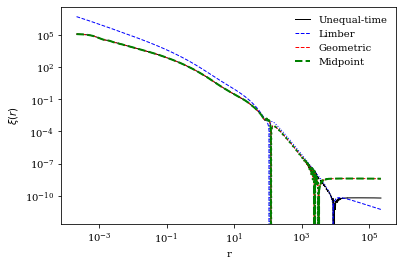

In [21]:
plt.figure(figsize=(6,4))
plt.loglog(r_uet, +xi_uet[0,0], 'k', label='Unequal-time', lw=1)
plt.loglog(r_uet, -xi_uet[0,0], '--k', lw=1)
plt.loglog(r_limb, +xi_limb[0], '--b', label='Limber', lw=1)
plt.loglog(r_limb, -xi_limb[0], ':b', lw=1)
plt.loglog(r_geom, +xi_geom[0,0], '--r', label='Geometric', lw=1)
plt.loglog(r_geom, -xi_geom[0,0], ':r', lw=1)
plt.loglog(r_mid, +xi_mid[0,0], '--g', label='Midpoint', lw=2)
plt.loglog(r_mid, -xi_mid[0,0], ':g', lw=2)

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [24]:
from lens_filter import filter_galaxy_clustering

* Redshift distribution of galaxies

In [25]:
zn = np.loadtxt('../../data/des-y1-test/nz_lens/z.txt')
nz = [np.loadtxt('../../data/des-y1-test/nz_lens/bin_%d.txt' % i) for i in range(1, nbin+1)]

In [26]:
xf = np.interp(zn, zdM, dM)

* Galaxy clustering

In [27]:
bias_DESY1 = [1.45, 1.55, 1.65, 1.8, 2.0]

In [28]:
fg = [filter_galaxy_clustering(xf, zn, n, bias, cosmo_astropy) for n,bias in zip(nz,bias_DESY1)]

## 4. Angular correlation function

In [31]:
theta = np.logspace(-3, np.log10(np.pi), 2048)
theta_arcmin = np.degrees(theta)*60

In [32]:
w_limb = [corfu.eqt(theta, (xf, fg[a-1]*fg[b-1]), (xp, r_limb, xi_limb)) for a, b in zip(bin_a, bin_b)]

In [33]:
w_geom = [corfu.uneqt(theta, (xf, fg[a-1]), (xf, fg[b-1]), (xp, xp, r_geom, xi_geom), 1) for a, b in zip(bin_a, bin_b)]

100%|██████████| 46/46 [00:14<00:00,  3.23it/s]


In [34]:
w_uet = [corfu.uneqt(theta, (xf, fg[a-1]), (xf, fg[b-1]), (xp, xp, r_uet, xi_uet), True) for a, b in zip(bin_a, bin_b)]

100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


In [35]:
w_mid = [corfu.uneqt(theta, (xf, fg[a-1]), (xf, fg[b-1]), (xp, xp, r_mid, xi_mid), True) for a, b in zip(bin_a, bin_b)]

100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


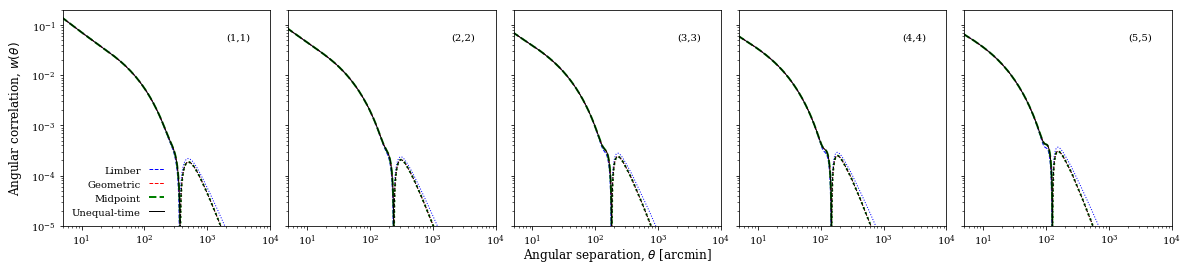

In [47]:
fig, axes = plt.subplots(1,5, figsize=(17, 4), sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_a, bin_b)):
    if a == b:
        ax = axes[b-1]
        ax.axis('on')
        ax.loglog(theta_arcmin, +w_limb[i], '--b', label='Limber', lw=1)
        ax.loglog(theta_arcmin, -w_limb[i], ':b', lw=1)
        ax.loglog(theta_arcmin, +w_geom[i], '--r', label='Geometric', lw=1)
        ax.loglog(theta_arcmin, -w_geom[i], ':r', lw=1)
        ax.loglog(theta_arcmin, +w_mid[i], '--g', label='Midpoint', lw=2)
        ax.loglog(theta_arcmin, -w_mid[i], ':g', lw=2)
        ax.loglog(theta_arcmin, +w_uet[i], 'k', label='Unequal-time', lw=1)
        ax.loglog(theta_arcmin, -w_uet[i], '--k', lw=1)
    
        ax.set_xlim(5e0, 1e4)
        ax.set_ylim(1e-5, 2e-1)
        ax.set_xticks([1e1, 1e2, 1e3, 1e4])
        ax.tick_params(axis='y', which='minor', labelcolor='none')
        string = '({0},{1})'.format(a,b)
        ax.text(2e3,5e-2,string)

axes[0].legend(markerfirst=False, loc='lower left', frameon=False)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular separation, $\theta$ [arcmin]', size=12)
ax.set_ylabel(r'Angular correlation, $w(\theta)$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=15)

fig.tight_layout(pad=0.5)

# fig.savefig('plots/w_galaxy_clustering.pdf', bbox_inches='tight')


plt.show()

## 5. Angular power spectrum analysis

### 5.1. Angular power spectra

In [37]:
l_limb, cl_limb = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_limb], (1, 0, 2))

In [38]:
l_geom, cl_geom = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_geom], (1, 0, 2))

In [39]:
l_uet, cl_uet = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_uet], (1, 0, 2))

In [40]:
l_mid, cl_mid = np.transpose([corfu.wtocl(theta, w, lmax=2000)for w in w_mid], (1, 0, 2))

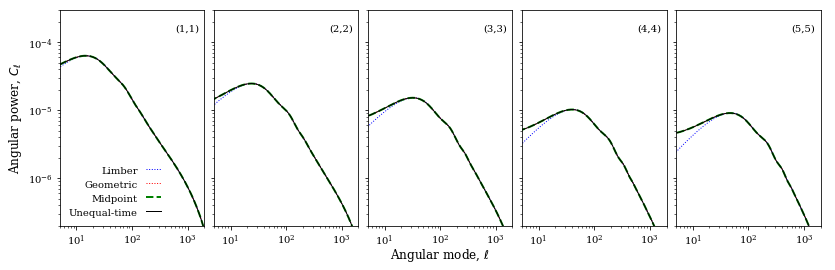

In [46]:
fig, axes = plt.subplots(1,5, figsize=(12, 4), sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_a, bin_b)):
    if a == b:
        ax = axes[b-1]
        ax.axis('on')
        ax.loglog(l_limb[i], cl_limb[i], ':b', label='Limber', lw=1)
        ax.loglog(l_geom[i], cl_geom[i], ':r', label='Geometric', lw=1) 
        ax.loglog(l_mid[i], cl_mid[i], '--g', label='Midpoint', lw=2)
        ax.loglog(l_uet[i], cl_uet[i], 'k', label='Unequal-time', lw=1)
        
        ax.set_xlim(5e0, 2e3)
        ax.set_ylim(2e-7, 3e-4)
        ax.set_xticks([1e1, 1e2, 1e3])
        string = '({0},{1})'.format(a,b)
        ax.text(6e2,1.5e-4,string)

axes[0].legend(markerfirst=False, loc='lower left', frameon=False)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular mode, $\ell$', size=12)
ax.set_ylabel(r'Angular power, $C_{\ell}$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

fig.tight_layout(pad=0.5)

# fig.savefig('plots/cl_galaxy_clustering.pdf', bbox_inches='tight')

plt.show()

### 5.2. Relative error

In [42]:
frac_limb = cl_limb/cl_uet 
frac_geom = cl_geom/cl_uet
frac_mid = cl_mid/cl_uet
frac_uet = cl_uet/cl_uet

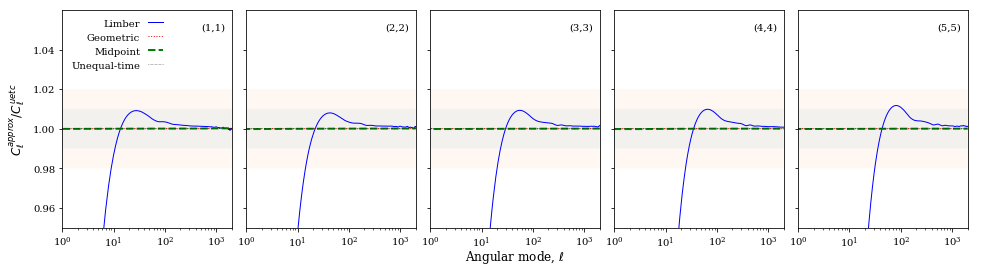

In [45]:
fig, axes = plt.subplots(1,5, figsize=(14, 4), sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(bin_a, bin_b)):
    if a == b:
        ax = axes[b-1]
        ax.axis('on')
        ax.semilogx(l_limb[i], frac_limb[i], 'b', label='Limber', lw=1)
        ax.semilogx(l_geom[i], frac_geom[i], ':r', label='Geometric', lw=1) 
        ax.semilogx(l_mid[i], frac_mid[i], '--g', label='Midpoint', lw=2)
        ax.semilogx(l_uet[i], frac_uet[i], ':k', label='Unequal-time', lw=0.5)
    
        ax.set_xlim(1, 2e3)
        ax.set_ylim(0.95, 1.06)
        ax.set_yticks([0.96, 0.98, 1, 1.02, 1.04])
        string = '({0},{1})'.format(a,b)
        ax.text(5e2,1.05,string)
        ax.fill_between(l_limb[0], 0.99, 1.01, alpha=0.05)
        ax.fill_between(l_limb[0], 0.98, 1.02, alpha=0.05)

axes[0].legend(markerfirst=False, loc='upper left', frameon=False)

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular mode, $\ell$', size=12)
ax.set_ylabel(r'$C_{\ell}^{approx} / C_{\ell}^{uetc}$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

fig.tight_layout(pad=0.5)

# fig.savefig('plots/fraction_cl_galaxy_clustering.pdf', bbox_inches='tight')

plt.show()